In [1]:
import torch
import torch.nn.functional as functional
from torchvision import transforms
from models import resnet50
from accessory_functions import dicom_path_to_tensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import cv2

normal_path = "../sa_images/normal/"
svp_path = "../sa_images/svp/"
# normal_pids = [] #will be list of normal pids
# for pid in os.listdir(normal_path):
#     normal_pids.append(pid)
# svp_pids = [] #will be list of svp pids
# for pid in os.listdir(svp_path):
#     svp_pids.append(pid)
# random.seed(10)
# test_svp_pids = random.sample(svp_pids,6) #each PID should be a full path to that PID directory
# test_normal_pids = random.sample(normal_pids,9)
# notest_normal_pids = list(set(normal_pids) - set(test_normal_pids))
# notest_svp_pids = list(set(svp_pids) - set(test_svp_pids))
# random.shuffle(notest_normal_pids)
# random.shuffle(notest_svp_pids)
# svp_folds = []
# normal_folds = []
# svp_fold_size = len(notest_svp_pids) // 4
# normal_fold_size = len(notest_normal_pids) // 4
# for i in range(4):
#     if i != 3:
#         svp_folds.append(notest_svp_pids[i*svp_fold_size:(i+1)*svp_fold_size])
#         normal_folds.append(notest_normal_pids[i*normal_fold_size:(i+1)*normal_fold_size])
#     elif i == 3:
#         svp_folds.append(notest_svp_pids[i*svp_fold_size:])
#         normal_folds.append(notest_normal_pids[i*normal_fold_size:])

# Load the model
model = resnet50(pretrained=True)
model_weight_path = "./saved_models/resnet50_fold0_pretrained.pth"
model.load_state_dict(torch.load(model_weight_path,map_location=torch.device('cpu')))
model.eval()

#find best-performing PID
analysis_csv = pd.read_csv("analysis_csvs/resnet50_fold0_pretrained.csv")
test_svp_df = analysis_csv[analysis_csv["pid"] == "0477DED9B19009165FEF2F0440917C2C"].iloc[0]['path']
print(test_svp_df)
# test_svp_csv = analysis_csv[analysis_csv["pid"] == test_svp_pids[0]]
# test_example = test_svp_csv.iloc[0]
# example_img_path = test_example['path']
# for date in test_svp_csv['date'].unique():
#     date_csv = test_svp_csv[test_svp_csv['date'] == date]
#     z_csv = date_csv[date_csv['z_coord'] == -19.311980]
#     t_csv = z_csv[z_csv['time'] == z_csv['time'].min()]
#     break
# example_img_path = t_csv['path'].item()

# Load the image
example_img_path = "../sa_images/svp/0477DED9B19009165FEF2F0440917C2C/20210510_flash_retro_cine_SA  fa25/1.3.12.2.1107.5.2.41.69604.2021051014595713198413468.1.0.0/d3f5b9c6-d9c592b0-9e11e257-616f265a-2051d780.dcm"
# example_img_path = "../sa_images/normal/00043FE7251F3F6735FDA0B23BC77261/20200624_Cine SA multi/1.3.12.2.1107.5.2.41.69604.2020062413184891492304520.5.0.0/040225f2-e9f56fe9-949aaeab-1921e08c-d1ede6ee.dcm"
img = dicom_path_to_tensor(example_img_path,224,train=False)
img_input = img.unsqueeze(0)

AttributeError: module 'torch.library' has no attribute 'register_fake'

In [ ]:
# Perform a forward pass to get the model's predictions
output = model(img_input)
predicted_class = output.argmax(dim=1).item()

# Get the gradients of the predicted class with respect to the feature maps of the last convolutional layer
model.zero_grad()
output[0, predicted_class].backward()

# Get the gradients and the feature maps
gradients = model.layer4[2].conv3.weight.grad
feature_maps = model.layer4[2].conv3.weight

# Compute the guided gradients
guided_gradients = torch.mean(gradients, dim=[0, 2, 3])

# Compute the heatmap
heatmap = torch.mean(guided_gradients * feature_maps.squeeze(), dim=1).squeeze()
# heatmap = torch.mean(heatmap, axis=0) #custom addition
heatmap = functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heatmap to a numpy array
heatmap = heatmap.detach().numpy()

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on the original image
heatmap = np.uint8(255 * heatmap)
heatmap = Image.fromarray(heatmap).resize((img.size[0], img.size[1]), Image.ANTIALIAS)
heatmap = np.array(heatmap)
superimposed_img = np.array(img) * 0.6 + heatmap[:, :, np.newaxis] * 0.4
superimposed_img = Image.fromarray(np.uint8(superimposed_img))
superimposed_img.show()

In [61]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks for gradients and activations
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.full_backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def full_backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def compute_heatmap(self, input_batch, class_idx=None):
        # Forward pass
        logits = self.model(input_batch)
        self.model.zero_grad()

        if class_idx is None:
            class_idx = torch.argmax(logits, dim=1).item()

        # Compute gradients for the target class
        one_hot_output = torch.zeros_like(logits)
        one_hot_output[0, class_idx] = 1
        logits.backward(gradient=one_hot_output)

        # Compute Grad-CAM heatmap
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activations, dim=1, keepdim=True)
        heatmap = torch.relu(heatmap)  # ReLU removes negative values
        heatmap /= torch.max(heatmap)  # Normalize to [0, 1]

        # Get the predicted class probability
        probs = torch.softmax(logits, dim=1)
        predicted_prob = probs[0, class_idx].item()

        return heatmap.squeeze().cpu().numpy(), class_idx, predicted_prob

In [62]:
gradcam = GradCAM(model, model.layer4[2].conv3)
heatmap, predicted_class_idx, predicted_prob = gradcam.compute_heatmap(img_input)

In [39]:
heatmap.shape
tets = Image.fromarray(heatmap).resize((img.size[0], img.size[1]), Image.ANTIALIAS)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [44]:
test_img = Image.fromarray(heatmap).resize((224,224))
np_img = np.array(test_img)

In [46]:
np_img.shape

(224, 224)

In [47]:
def visualize_heatmap(img: np.ndarray, heatmap: np.ndarray) -> None:
    # Read the image from the given file path
    # img = cv2.imread(img_path)
    
    # Resize the heatmap to match the size of the original image
    # heatmap = np.uint8(255 * heatmap)
    # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = Image.fromarray(heatmap).resize((224,224))
    heatmap = np.array(heatmap)
    
    # Normalize the heatmap values to the range [0, 255] and cast to uint8
    heatmap = np.uint8(255 * heatmap)
    
    # Apply the JET colormap to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Blend the original image with the heatmap (60% original, 40% heatmap)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the blended image in RGB format
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [48]:
visualize_heatmap(img.squeeze(),heatmap)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'applyColorMap'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [51]:
cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'applyColorMap'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


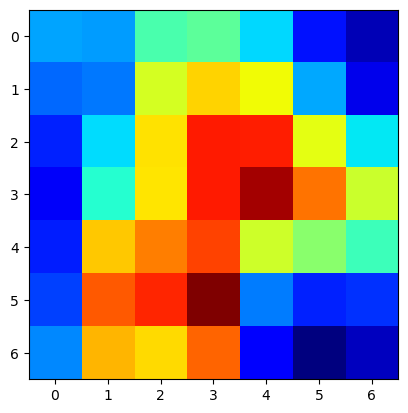

In [76]:
colormap = plt.get_cmap('jet')
colored_heatmap = colormap(heatmap)
plt.imshow(colored_heatmap)#,cmap='jet')

In [78]:
colored_heatmap.shape

(7, 7, 4)

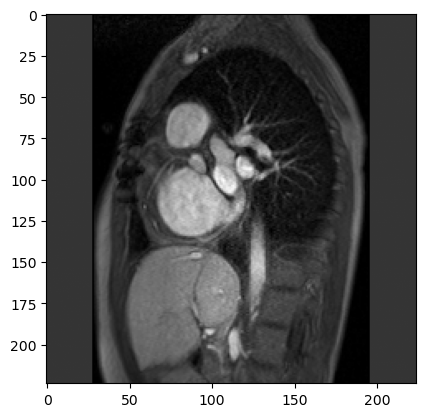

In [64]:
plt.imshow(img.squeeze(),cmap='gray')

In [67]:
img.min()

tensor(-0.8868)

In [22]:
cv2.resize(heatmap,(10,10))

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [25]:
heatmap.min()

np.float32(0.0)

In [1]:
# test analysis csvs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('analysis_csvs/resnet50_fold0_pretrained.csv')

In [5]:
analysis_csv = pd.read_csv("analysis_csvs/resnet50_fold0_pretrained.csv")

In [25]:
gradients.shape
feature_maps.shape

In [45]:
test_heatmap = guided_gradients * feature_maps.squeeze()

In [48]:
torch.mean(test_heatmap,dim=1).shape

In [44]:
feature_maps.squeeze().shape

In [35]:
guided_gradients.shape
heatmap.shape

In [20]:
analysis_csv['z_coord'].median()

In [9]:
sorted(date_csv['z_coord'].unique())

In [49]:
np.sqrt(2048)

In [68]:
from pydicom import dcmread
dcm = dcmread(example_img_path)
array = dcm.pixel_array

In [71]:
array.min()

np.uint16(0)

In [ ]:
model.layer4[2

SyntaxError: invalid syntax (2374418759.py, line 1)

In [57]:
analysis_csv[analysis_csv['pid'] == "0477DED9B19009165FEF2F0440917C2C"]['z_coord'].unique()

array([18.06405854, 88.0640997 , 38.06407174, 48.06407674, 58.06408527,
        8.06405208, 28.06406328, 98.06410518, 78.06409491, 68.06409011])

In [1]:
from pytorch_grad_cam import GradCam

AttributeError: module 'torch.library' has no attribute 'register_fake'

In [2]:
torch.__version__

NameError: name 'torch' is not defined

In [3]:
import torch
torch.__version__

'2.3.1'

In [4]:
import torchvision
torchvision.__version__

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [7]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50
from models import resnet50
from accessory_functions import dicom_path_to_tensor
import numpy as np
import torch
model = resnet50(pretrained=True)
model_weight_path = "./saved_models/resnet50_fold0_pretrained.pth"
model.load_state_dict(torch.load(model_weight_path,map_location=torch.device('cpu')))
model.eval()
target_layers = [model.layer4[-1]]
example_img_path = "../sa_images/svp/0477DED9B19009165FEF2F0440917C2C/20210510_flash_retro_cine_SA  fa25/1.3.12.2.1107.5.2.41.69604.2021051014595713198413468.1.0.0/d3f5b9c6-d9c592b0-9e11e257-616f265a-2051d780.dcm"
img = dicom_path_to_tensor(example_img_path,224,train=False)
input_tensor = img.unsqueeze(0)
# input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(0)]

img = img - img.min()
img = img / img.max()
rgb_img = np.stack((img,)*3, axis=-1)


# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

/home/connor_morris/miniconda3/envs/gradcam/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/connor_morris/miniconda3/envs/gradcam/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_81030/3632191989.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/

In [4]:
help(ClassifierOutputTarget)

Help on class ClassifierOutputTarget in module pytorch_grad_cam.utils.model_targets:

class ClassifierOutputTarget(builtins.object)
 |  ClassifierOutputTarget(category)
 |  
 |  Methods defined here:
 |  
 |  __call__(self, model_output)
 |      Call self as a function.
 |  
 |  __init__(self, category)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [8]:
model_outputs

tensor([[8.0208]], grad_fn=<AddmmBackward0>)

(-0.5, 223.5, 223.5, -0.5)

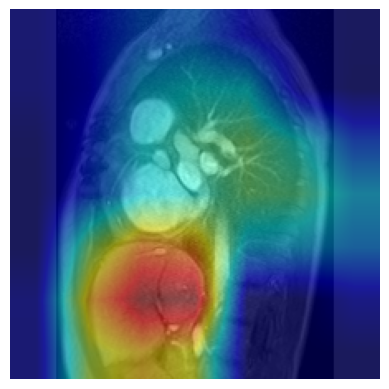

In [15]:
from matplotlib import pyplot as plt
plt.imshow(visualization.squeeze())
plt.axis('off')

In [12]:
visualization.shape

(1, 224, 224, 3)